In [13]:
from litgpt import LLM

llm = LLM.load("/workspace/budget-checkpointing/model_hub/Llama-3.2-1B/")
text = llm.generate("good work")
print(text)

 pen and paper sheets for younger children with less handwriting ie pen moves but sensitive to marking pressure in pastel coloured crayones.
There are numerous session on building fairytale scenes from the mark with regents secondary school level should write assessments 92 differentiated


# Debug utils

## Imports

In [2]:
from functools import partial
from typing import Callable, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn

from transformers.activations import ACT2FN
from transformers.cache_utils import Cache, DynamicCache, StaticCache
from transformers.generation import GenerationMixin
from transformers.modeling_attn_mask_utils import AttentionMaskConverter
from transformers.modeling_flash_attention_utils import FlashAttentionKwargs
from transformers.modeling_outputs import (
    BaseModelOutputWithPast,
    CausalLMOutputWithPast,
    QuestionAnsweringModelOutput,
    SequenceClassifierOutputWithPast,
    TokenClassifierOutput,
)
from transformers.modeling_rope_utils import ROPE_INIT_FUNCTIONS, dynamic_rope_update
from transformers.modeling_utils import ALL_ATTENTION_FUNCTIONS, PreTrainedModel
from transformers.processing_utils import Unpack
from transformers.pytorch_utils import ALL_LAYERNORM_LAYERS
from transformers.utils import (
    LossKwargs,
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    can_return_tuple,
    is_torch_flex_attn_available,
    logging,
    replace_return_docstrings,
)
from transformers.utils.deprecation import deprecate_kwarg
from models.llama.configuration_llama import LlamaConfig


if is_torch_flex_attn_available():
    from torch.nn.attention.flex_attention import BlockMask

    from transformers.integrations.flex_attention import make_flex_block_causal_mask


logger = logging.get_logger(__name__)

_CHECKPOINT_FOR_DOC = "meta-llama/Llama-2-7b-hf"
_CONFIG_FOR_DOC = "LlamaConfig"

In [26]:
class Output(dict):
    """
    Dictionary subclass that allows attribute-style access while maintaining
    normal dictionary access methods.
    """
    def __init__(self, *args, **kwargs):
        super(Output, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
    def __getitem__(self, key):
        return super(Output, self).__getitem__(key)
    
    def __setitem__(self, key, value):
        super(Output, self).__setitem__(key, value)
        
    def copy(self):
        return Output(self)

## Utils

In [8]:
from transformers import AutoTokenizer
from models.llama.modeling_llama import LlamaForCausalLM
import torch

model_id = "/workspace/budget-checkpointing/model_hub/Llama-3.2-1B/"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = LlamaForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16)
model = model.to("cuda:0")

In [137]:
text = "When I was I kid I used to"
texts = [
    "Hanoi is the capital of Vietnam.",
    "Boys are stupid."
]

In [39]:
def init_decoder_input(
    text, model, tokenizer, 
    use_cache=False, 
    output_hidden_states=True, 
    output_attentions=False
):
    """
    Initialize the input for LlamaModel forward pass.
    
    Args:
        text: Text to tokenize and process
        model: LlamaModel instance
        tokenizer: LlamaTokenizer instance
        use_cache: Whether to use KV cache
        output_hidden_states: Whether to output all hidden states
        output_attentions: Whether to output attention weights
        
    Returns:
        Dictionary with all required inputs for model forward pass
    """
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    
    # Initialize caching variables
    past_key_values = DynamicCache() if use_cache else None
    
    model.eval()
    
    with torch.no_grad():
        # Get input embeddings
        inputs_embeds = model.embed_tokens(input_ids)
        
        # Calculate cache position
        cache_position = None
        past_seen_tokens = past_key_values.get_seq_length() if past_key_values is not None else 0
        cache_position = torch.arange(
            past_seen_tokens, 
            past_seen_tokens + inputs_embeds.shape[1], 
            device=inputs_embeds.device
        )
        
        # Calculate position IDs
        position_ids = cache_position.unsqueeze(0)
        
        # Create causal mask
        causal_mask = model._update_causal_mask(
            attention_mask, 
            inputs_embeds, 
            cache_position, 
            past_key_values, 
            output_attentions
        )
        
        # Initial hidden states are just the input embeddings
        hidden_states = inputs_embeds
        
        # Create position embeddings
        position_embeddings = model.rotary_emb(hidden_states, position_ids)
    
    # Return all inputs needed for model.forward()
    return Output(
        input_ids=input_ids,
        attention_mask=causal_mask,
        position_ids=position_ids,
        past_key_values=past_key_values,
        inputs_embeds=inputs_embeds,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        cache_position=cache_position,
        position_embeddings=position_embeddings,
    )

In [43]:
decoder_input = init_input(
    text=text,
    model=model.model,
    tokenizer=tokenizer
)

In [42]:
def decoder_forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Cache] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = False,
        cache_position: Optional[torch.LongTensor] = None,
        position_embeddings: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,  # necessary, but kept here for BC
        **kwargs: Unpack[FlashAttentionKwargs],
) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
        
        checkpoints = []
        residual = hidden_states
        checkpoints.append(dict(value=residual, desc="residual"))

        hidden_states = self.input_layernorm(hidden_states)
        checkpoints.append(dict(value=hidden_states, desc="after input_layernorm"))

        # Self Attention
        hidden_states, self_attn_weights = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_value=past_key_value,
            output_attentions=output_attentions,
            use_cache=use_cache,
            cache_position=cache_position,
            position_embeddings=position_embeddings,
            **kwargs,
        )
        checkpoints.append(dict(value=hidden_states, desc="after self_attn"))

        hidden_states = residual + hidden_states
        checkpoints.append(dict(value=hidden_states, desc="after first skip connection"))

        # Fully Connected
        residual = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)
        checkpoints.append(dict(value=hidden_states, desc="after post_attention_layernorm"))
        hidden_states = self.mlp(hidden_states)
        checkpoints.append(dict(value=hidden_states, desc="after mlp"))
        hidden_states = residual + hidden_states
        checkpoints.append(dict(value=hidden_states, desc="after second skip connection"))

        outputs = (hidden_states,)
        if output_attentions:
            outputs += (self_attn_weights,)

        return Output(
            outputs=outputs,
            checkpoints=checkpoints
        )


In [50]:
decoder_input.keys()

dict_keys(['input_ids', 'attention_mask', 'position_ids', 'past_key_values', 'inputs_embeds', 'use_cache', 'output_attentions', 'output_hidden_states', 'cache_position', 'position_embeddings'])

In [85]:
decoder_input.attention_mask

In [45]:
decoder0 = model.model.layers[0]
decoder0

LlamaDecoderLayer(
  (self_attn): LlamaAttention(
    (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (k_proj): Linear(in_features=2048, out_features=512, bias=False)
    (v_proj): Linear(in_features=2048, out_features=512, bias=False)
    (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
    (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
    (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
)

In [53]:
decoder_output = decoder_forward(
    self=model.model.layers[0],
    hidden_states=decoder_input.inputs_embeds,
    attention_mask=decoder_input.attention_mask,
    position_ids=decoder_input.position_ids,
    past_key_value=decoder_input.past_key_values,
    output_attentions=False,
    use_cache=False,
    cache_position=decoder_input.cache_position,
    position_embeddings=decoder_input.position_embeddings,
)

In [55]:
decoder_output.checkpoints[0]

{'value': tensor([[[ 0.0028,  0.0033, -0.0099,  ..., -0.0018,  0.0008,  0.0007],
          [ 0.0248, -0.0036,  0.0308,  ...,  0.0057, -0.0294, -0.0105],
          [ 0.0233,  0.0102,  0.0383,  ..., -0.0037, -0.0302, -0.0154],
          ...,
          [ 0.0233,  0.0102,  0.0383,  ..., -0.0037, -0.0302, -0.0154],
          [-0.0284, -0.0045, -0.0004,  ...,  0.0129, -0.0276, -0.0047],
          [-0.0151,  0.0303,  0.0200,  ..., -0.0099,  0.0095, -0.0204]]],
        device='cuda:0', dtype=torch.bfloat16),
 'desc': 'residual'}

In [133]:
def model_forward(
    self,
    input_ids: Optional[torch.LongTensor] = None,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_values: Optional[Cache] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    cache_position: Optional[torch.LongTensor] = None,
    **flash_attn_kwargs: Unpack[FlashAttentionKwargs],
) -> BaseModelOutputWithPast:
    output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    output_hidden_states = (
        output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    )
    use_cache = use_cache if use_cache is not None else self.config.use_cache

    if (input_ids is None) ^ (inputs_embeds is not None):
        raise ValueError("You must specify exactly one of input_ids or inputs_embeds")

    # TODO (joao): remove this exception in v4.56 -- it exists for users that try to pass a legacy cache
    if not isinstance(past_key_values, (type(None), Cache)):
        raise ValueError("The `past_key_values` should be either a `Cache` object or `None`.")

    if inputs_embeds is None:
        inputs_embeds = self.embed_tokens(input_ids)

    if use_cache and past_key_values is None:
        past_key_values = DynamicCache()

    if cache_position is None:
        past_seen_tokens = past_key_values.get_seq_length() if past_key_values is not None else 0
        cache_position = torch.arange(
            past_seen_tokens, past_seen_tokens + inputs_embeds.shape[1], device=inputs_embeds.device
        )

    if position_ids is None:
        position_ids = cache_position.unsqueeze(0)

    causal_mask = self._update_causal_mask(
        attention_mask, inputs_embeds, cache_position, past_key_values, output_attentions
    )

    hidden_states = inputs_embeds

    # create position embeddings to be shared across the decoder layers
    position_embeddings = self.rotary_emb(hidden_states, position_ids)

    # decoder layers
    all_hidden_states = () if output_hidden_states else None
    all_self_attns = () if output_attentions else None
    all_checkpoints = []

    for decoder_layer in self.layers[: self.config.num_hidden_layers]:
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        debug_output = decoder_forward(
            decoder_layer,
            hidden_states,
            attention_mask=causal_mask,
            position_ids=position_ids,
            past_key_value=past_key_values,
            output_attentions=output_attentions,
            use_cache=use_cache,
            cache_position=cache_position,
            position_embeddings=position_embeddings,
            **flash_attn_kwargs,
        )

        layer_outputs, checkpoints = debug_output.outputs, debug_output.checkpoints
        hidden_states = layer_outputs[0]
        all_checkpoints.append(checkpoints)

        if output_attentions:
            all_self_attns += (layer_outputs[1],)

    hidden_states = self.norm(hidden_states)

    # add hidden states from the last decoder layer
    if output_hidden_states:
        all_hidden_states += (hidden_states,)

    outputs = BaseModelOutputWithPast(
        last_hidden_state=hidden_states,
        past_key_values=past_key_values if use_cache else None,
        hidden_states=all_hidden_states,
        attentions=all_self_attns,
    )

    return Output(
        outputs=outputs,
        decoder_checkpoints=all_checkpoints,
    )

In [134]:
inputs = tokenizer(text, return_tensors="pt").to(model.device)
input_ids = inputs["input_ids"]
model_output = model_forward(model.model, input_ids)

In [76]:
from models.llama.modeling_llama import apply_rotary_pos_emb
from models.llama.modeling_llama import eager_attention_forward
def attn_forward(
    self,
    hidden_states: torch.Tensor,
    position_embeddings: Tuple[torch.Tensor, torch.Tensor],
    attention_mask: Optional[torch.Tensor],
    past_key_value: Optional[Cache] = None,
    cache_position: Optional[torch.LongTensor] = None,
    **kwargs: Unpack[FlashAttentionKwargs],
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    checkpoints = []
    checkpoints.append(dict(value=hidden_states, desc="input_hidden_states")) # 0
    
    input_shape = hidden_states.shape[:-1]
    hidden_shape = (*input_shape, -1, self.head_dim)

    query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
    checkpoints.append(dict(value=query_states, desc="after_q_proj")) # 1
    
    key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
    checkpoints.append(dict(value=key_states, desc="after_k_proj")) # 2
    
    value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)
    checkpoints.append(dict(value=value_states, desc="after_v_proj")) # 3

    cos, sin = position_embeddings
    query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)
    checkpoints.append(dict(value=query_states, desc="after_rotary_pos_emb_query")) # 4
    checkpoints.append(dict(value=key_states, desc="after_rotary_pos_emb_key")) # 5

    if past_key_value is not None:
        # sin and cos are specific to RoPE models; cache_position needed for the static cache
        cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
        key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)
        checkpoints.append(dict(value=key_states, desc="after_kv_cache_update_key")) # 6
        checkpoints.append(dict(value=value_states, desc="after_kv_cache_update_value")) # 7

    attention_interface: Callable = eager_attention_forward
    if self.config._attn_implementation != "eager":
        if self.config._attn_implementation == "sdpa" and kwargs.get("output_attentions", False):
            logger.warning(
                "`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to "
                'eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.'
            )
        else:
            attention_interface = ALL_ATTENTION_FUNCTIONS[self.config._attn_implementation]

    attn_output, attn_weights = attention_interface(
        self,
        query_states,
        key_states,
        value_states,
        attention_mask,
        dropout=0.0 if not self.training else self.attention_dropout,
        scaling=self.scaling,
        **kwargs,
    )
    checkpoints.append(dict(value=attn_output, desc="after_attention")) # 6/8

    attn_output = attn_output.reshape(*input_shape, -1).contiguous()
    checkpoints.append(dict(value=attn_output, desc="after_reshape")) # 7/9
    
    attn_output = self.o_proj(attn_output)
    checkpoints.append(dict(value=attn_output, desc="after_o_proj")) # 8/10
    
    return Output(
        outputs=(attn_output, attn_weights),
        checkpoints=checkpoints,
        attention_interface=attention_interface
    )

In [72]:
self_attn = model.model.layers[0].self_attn
self_attn, self_attn.num_key_value_groups

(LlamaAttention(
   (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
   (k_proj): Linear(in_features=2048, out_features=512, bias=False)
   (v_proj): Linear(in_features=2048, out_features=512, bias=False)
   (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
 ),
 4)

In [63]:
attn_output = attn_forward(
    self=model.model.layers[0].self_attn,
    hidden_states=decoder_input.inputs_embeds,
    position_embeddings=decoder_input.position_embeddings,
    attention_mask=decoder_input.attention_mask,
    past_key_value=decoder_input.past_key_values,
    cache_position=decoder_input.cache_position
)

In [79]:
query_states = attn_output.checkpoints[4]["value"]
key_states = attn_output.checkpoints[5]["value"]
value_states = attn_output.checkpoints[3]["value"]

In [71]:
# Original SDPA employed by Huggingface

from typing import Optional, Tuple

import torch


def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


def sdpa_attention_forward(
    module: torch.nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    dropout: float = 0.0,
    scaling: Optional[float] = None,
    is_causal: Optional[bool] = None,
    **kwargs,
) -> Tuple[torch.Tensor, None]:
    if hasattr(module, "num_key_value_groups"):
        key = repeat_kv(key, module.num_key_value_groups)
        value = repeat_kv(value, module.num_key_value_groups)

    causal_mask = attention_mask
    if attention_mask is not None and causal_mask.ndim == 4:
        causal_mask = causal_mask[:, :, :, : key.shape[-2]]

    # SDPA with memory-efficient backend is bugged with non-contiguous inputs and custom attn_mask for some torch versions
    # Reference: https://github.com/pytorch/pytorch/issues/112577.
    query = query.contiguous()
    key = key.contiguous()
    value = value.contiguous()

    # We dispatch to SDPA's Flash Attention or Efficient kernels via this `is_causal` if statement instead of an inline conditional assignment
    # in SDPA to support both torch.compile's dynamic shapes and full graph options. An inline conditional prevents dynamic shapes from compiling.
    # Note that it is important to check first for the shape, otherwise compile will fail with `argument 'is_causal' must be bool, not SymBool`
    if is_causal is None:
        is_causal = query.shape[2] > 1 and causal_mask is None

    # Shapes (e.g. query.shape[2]) are tensors during jit tracing, resulting in `is_causal` being a tensor.
    # We convert it to a bool for the SDPA kernel that only accepts bools.
    if torch.jit.is_tracing() and isinstance(is_causal, torch.Tensor):
        is_causal = is_causal.item()

    attn_output = torch.nn.functional.scaled_dot_product_attention(
        query,
        key,
        value,
        attn_mask=causal_mask,
        dropout_p=dropout,
        scale=scaling,
        is_causal=is_causal,
    )
    attn_output = attn_output.transpose(1, 2).contiguous()

    return attn_output, None

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
from typing import Optional, Union

def visualize_mask(
    mask: Union[torch.Tensor, np.ndarray],
    name: str = "attention_mask",
    path: Optional[Path] = None,
    cmap: str = "Blues",
    figsize: tuple = (8, 6),
) -> Path:
    """Visualize an attention mask matrix."""
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()
    if mask.dtype == bool:
        mask = mask.astype(np.int32)
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(mask, cmap=cmap)
    fig.colorbar(im)
    
    ax.set_title(name.replace("_", " ").title())
    ax.set_xlabel("Key Tokens")
    ax.set_ylabel("Query Tokens")
    
    n_query, n_kv = mask.shape
    if n_query <= 32 and n_kv <= 32:
        ax.set_xticks(range(n_kv))
        ax.set_xticklabels([f"K{i}" for i in range(n_kv)])
        ax.set_yticks(range(n_query))
        ax.set_yticklabels([f"Q{i}" for i in range(n_query)])
        # ax.grid(color="black", linestyle="-", linewidth=0.5)
        
        # Align grid with pixel boundaries
        ax.set_xticks(np.arange(-0.5, n_kv, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, n_query, 1), minor=True)
        ax.grid(which="minor", color="black", linestyle="-", linewidth=1)

    plt.show()

In [86]:
query_states.shape

torch.Size([1, 32, 9, 64])

In [94]:
attn_output1, _ = sdpa_attention_forward(
    module=model.model.layers[0].self_attn,
    query=query_states,
    key=key_states,
    value=value_states,
    attention_mask=None,
    dropout=0.0,
    scale=None,
    is_causal=True
)

In [84]:
attn_output.shape

torch.Size([1, 9, 32, 64])

In [89]:
key_states.shape[-2]

9

In [92]:
from torch.nn.attention.flex_attention import create_mask
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

S = query_states.shape[-2]
manual_mask = create_mask(causal_mask, 1, 1, S, S, device=query_states.device)

In [95]:
attn_output2, _ = sdpa_attention_forward(
    module=model.model.layers[0].self_attn,
    query=query_states,
    key=key_states,
    value=value_states,
    attention_mask=manual_mask,
    dropout=0.0,
    scale=None,
    is_causal=True
)

In [97]:
torch.testing.assert_close(attn_output1, attn_output2)

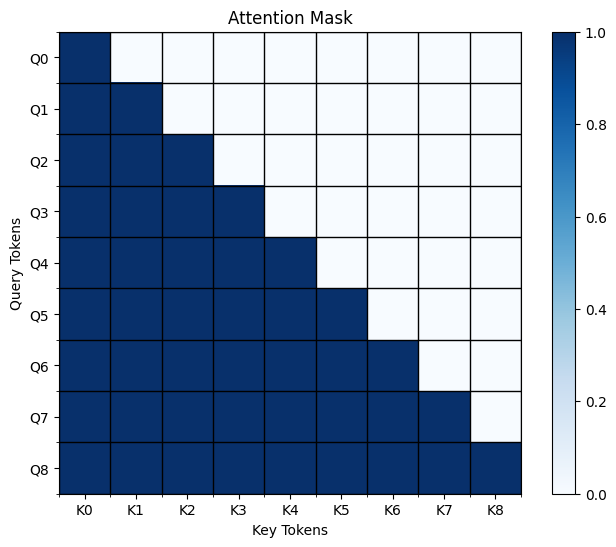

In [122]:
visualize_mask(manual_mask[0,0,:,:])

In [111]:
inputs = tokenizer(text, return_tensors="pt").to(model.device)
inputs["attention_mask"]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')